In [1]:
!pip install indoNLP stanza emoji Sastrawi bertopic sentence-transformers minisom hdbscan optuna transformers torch -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00


In [16]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import nltk
import shutil
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tqdm.auto as tqdm
import spacy
import os
import emoji
import torch
import subprocess
import requests
import string
import stanza

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob
from nltk import ngrams
from tqdm import tqdm

warnings.filterwarnings("ignore")

# **Import Data**

In [3]:
os.makedirs("/content/Raw_Dataset/", exist_ok=True)

file_names = [f"coretax-pt{name}.csv" for name in range(1, 13)]

for file_name in file_names:
    url = f"https://raw.githubusercontent.com/rioooranteai/nlp-simple-project/main/Analisis%20Sentimen%20-%20Coretax/Dataset/Raw%20Data/{file_name}"
    output_path = f"/content/Raw_Dataset/{file_name}"

    response = requests.get(url)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            f.write(response.content)
        print(f"Berhasil mengunduh {file_name}")
    else:
        print(f"Gagal mengunduh {file_name}: Status code {response.status_code}")


Berhasil mengunduh coretax-pt1.csv
Berhasil mengunduh coretax-pt2.csv
Berhasil mengunduh coretax-pt3.csv
Berhasil mengunduh coretax-pt4.csv
Berhasil mengunduh coretax-pt5.csv
Berhasil mengunduh coretax-pt6.csv
Berhasil mengunduh coretax-pt7.csv
Berhasil mengunduh coretax-pt8.csv
Berhasil mengunduh coretax-pt9.csv
Berhasil mengunduh coretax-pt10.csv
Berhasil mengunduh coretax-pt11.csv
Berhasil mengunduh coretax-pt12.csv


In [4]:
list_dataframe = []

for name in range(1, 13):
    df_temp = pd.read_csv(f"/content/Raw_Dataset/coretax-pt{name}.csv")
    list_dataframe.append(df_temp)

In [5]:
df = pd.concat(list_dataframe, ignore_index=True)

In [6]:
df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1912383957599154665,Wed Apr 16 07:24:25 +0000 2025,0,@dizol97 Hai Kak. Mohon maaf atas ketidaknyama...,1912406709710295309,NaN,dizol97,in,1500200,0,0,0,https://x.com/kring_pajak/status/1912406709710...,4564565058,kring_pajak
1,1912358077288050850,Wed Apr 16 07:23:51 +0000 2025,0,@dianariyanirs Hai Kak. Mohon maaf atas ketida...,1912406570971066443,NaN,dianariyanirs,in,1500200,0,0,0,https://x.com/kring_pajak/status/1912406570971...,4564565058,kring_pajak
2,1912373419292913896,Wed Apr 16 07:23:31 +0000 2025,1,@songofdaenerys Hai Kak. Apakah alamat Kakak p...,1912406486279680037,NaN,songofdaenerys,in,1500200,0,1,0,https://x.com/kring_pajak/status/1912406486279...,4564565058,kring_pajak
3,1912405898603164109,Wed Apr 16 07:21:11 +0000 2025,0,Hhaaai! Sha Open Jasa ya ges *Lapor SPT Masa P...,1912405898603164109,NaN,NaN,in,WA kesini yah :,0,0,0,https://x.com/chemomils/status/191240589860316...,1592475345537859587,chemomils
4,1901586514938884266,Wed Apr 16 07:20:38 +0000 2025,0,@kring_pajak @DitjenPajakRI Pajak yang dibayar...,1912405758408532461,https://pbs.twimg.com/media/Goo65ZwW0AAmODg.jpg,kring_pajak,in,NaN,0,0,0,https://x.com/yohadham/status/1912405758408532461,984596278897033216,yohadham


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15837 entries, 0 to 15836
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   conversation_id_str      15837 non-null  int64 
 1   created_at               15837 non-null  object
 2   favorite_count           15837 non-null  int64 
 3   full_text                15837 non-null  object
 4   id_str                   15837 non-null  int64 
 5   image_url                1864 non-null   object
 6   in_reply_to_screen_name  10247 non-null  object
 7   lang                     15837 non-null  object
 8   location                 9879 non-null   object
 9   quote_count              15837 non-null  int64 
 10  reply_count              15837 non-null  int64 
 11  retweet_count            15837 non-null  int64 
 12  tweet_url                15837 non-null  object
 13  user_id_str              15837 non-null  int64 
 14  username                 15837 non-nul

# **Text Preprocessing**

In [8]:
relevant_columns = 'full_text'
data = df[[relevant_columns]].copy(deep=True)

In [9]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [10]:
def data_cleaning_pipeline(text: str):
    if not isinstance(text, str):
        text = str(text)

    def remove_emojis(input_text):
        return emoji.replace_emoji(input_text, replace='')

    step_1 = remove_emojis(text)
    step_2 = re.sub(r'http\S+', '', step_1)
    step_3 = re.sub(r'\B[@#]\w+\b', '', step_2)
    step_4 = step_3.translate(str.maketrans('', '', string.punctuation))
    step_5 = re.sub(r'\s+', ' ', step_4)

    words = step_5.split()
    step_6 = ' '.join(sorted(set(words), key=words.index))

    return step_6.strip().lower()

In [11]:
data['full_text'] = data['full_text'].apply(data_cleaning_pipeline)
data.dropna(subset=["full_text"], inplace=True)
data.drop_duplicates(subset=['full_text'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [12]:
stanza.download('id', package='csui')

nlp = stanza.Pipeline(lang='id', processors='tokenize,pos,lemma', package='csui')

tqdm.pandas()

def lemmastanZa(teks):
    doc = nlp(teks)
    return " ".join([word.lemma for sentence in doc.sentences for word in sentence.words])

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading these customized packages for language: id (Indonesian)...
| Processor       | Package       |
-----------------------------------
| tokenize        | csui          |
| mwt             | csui          |
| pos             | csui_charlm   |
| lemma           | csui_nocharlm |
| depparse        | csui_charlm   |
| pretrain        | conll17       |
| backward_charlm | oscar2023     |
| forward_charlm  | oscar2023     |



INFO:stanza:Downloaded file to /root/stanza_resources/id/tokenize/csui.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/mwt/csui.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/pos/csui_charlm.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/lemma/csui_nocharlm.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/depparse/csui_charlm.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/pretrain/conll17.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/backward_charlm/oscar2023.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/forward_charlm/oscar2023.pt
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: id (Indonesian):
| Processor | Package       |
-----------------------------
| tokenize  | csui          |
| mwt       | csui          |
| pos       | csui_charlm   |
| lemma     | csui_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [13]:
data['full_text'] = data['full_text'].progress_apply(lemmastanZa)
data.dropna(subset=["full_text"], inplace=True)

100%|██████████| 14581/14581 [15:48<00:00, 15.37it/s]


In [14]:
data.drop_duplicates(subset=['full_text'], inplace=True)
data.reset_index(drop=True, inplace=True)

# **Labeling Data**

### Model 1

In [ ]:
pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)

def analyze_sentiment(text):
    if pd.isnull(text) or not isinstance(text, str):
        return {"label": "neutral", "score": 0.0}
    try:
        result = nlp(text)[0]
    except Exception as e:
        print(f"Error processing text: {text}, Error: {e}")
        return {"label": "neutral", "score": 0.0}
    return result

data['full_text'] = data['full_text'].astype(str)
data['sentiment_result'] = data['full_text'].apply(analyze_sentiment)

data['sentiment'] = data['sentiment_result'].apply(lambda x: x['label'])
data['sentiment_score'] = data['sentiment_result'].apply(lambda x: x['score'])

Device set to use cuda:0


Error processing text: , Error: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)


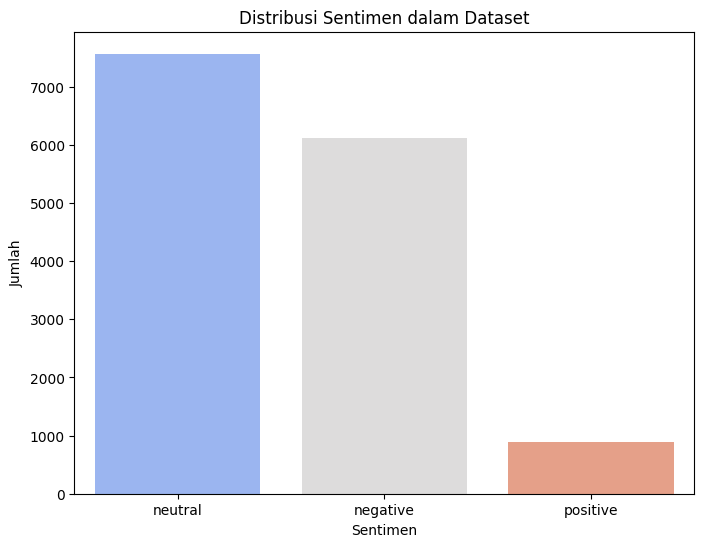

In [ ]:
sentiment_counts = data['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribusi Sentimen dalam Dataset")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

### Model 2

In [18]:
pretrained = "mdhugol/indonesia-bert-sentiment-classification"

model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

def analyze_sentiment_bert(text):

    result = sentiment_analysis(text)
    status = label_index[result[0]['label']]
    score = result[0]['score']

    return status

Device set to use cuda:0


In [20]:
data['full_text'] = data['full_text'].astype(str)
data['sentiment'] = data['full_text'].apply(analyze_sentiment_bert)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


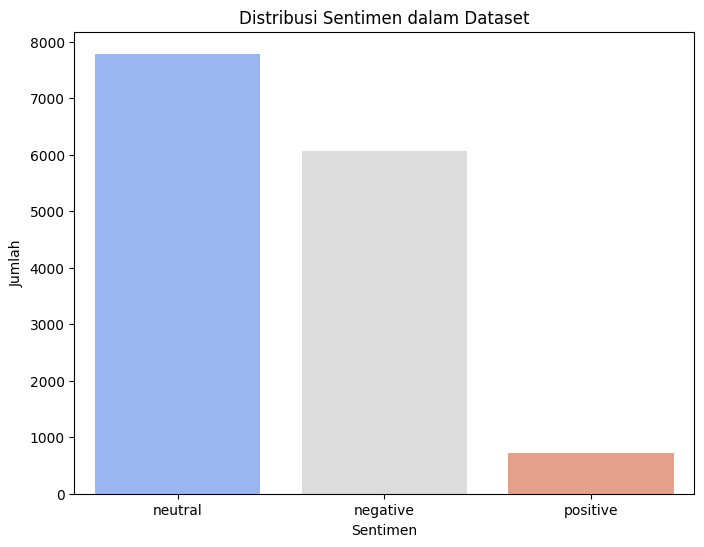

In [21]:
sentiment_counts = data['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribusi Sentimen dalam Dataset")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

In [22]:
data.to_csv('Dataset_v2.csv', index=False)